In this notebook, we will use YouTube data from Canada to perform various analyses with machine learning models and ultimately develop an algorithm to predict video views.

# Libraries

In [1]:
# Regular Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re

#Sci-kit Model Development
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

#Sci-kit Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
#Sci-kit Scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

#XGBoost Classifier
#!pip install XGBoost
from xgboost import XGBClassifier

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/youtube-new/GBvideos.csv
/kaggle/input/youtube-new/MXvideos.csv
/kaggle/input/youtube-new/KRvideos.csv
/kaggle/input/youtube-new/MX_category_id.json
/kaggle/input/youtube-new/GB_category_id.json
/kaggle/input/youtube-new/US_category_id.json
/kaggle/input/youtube-new/IN_category_id.json
/kaggle/input/youtube-new/DEvideos.csv
/kaggle/input/youtube-new/KR_category_id.json
/kaggle/input/youtube-new/RU_category_id.json
/kaggle/input/youtube-new/FRvideos.csv
/kaggle/input/youtube-new/USvideos.csv
/kaggle/input/youtube-new/INvideos.csv
/kaggle/input/youtube-new/RUvideos.csv
/kaggle/input/youtube-new/CA_category_id.json
/kaggle/input/youtube-new/DE_category_id.json
/kaggle/input/youtube-new/JP_category_id.json
/kaggle/input/youtube-new/JPvideos.csv
/kaggle/input/youtube-new/FR_category_id.json
/kaggle/input/youtube-new/CAvideos.csv


# Loading the Datasets

> Using json file to add the category column to the data replacing the category Id column

In [2]:
# Reading JSON file for categories
categories = pd.read_json("/kaggle/input/youtube-new/CA_category_id.json")
categories.head() # Displaying the categories DataFrame

,kind,etag,items
0,youtube#videoCategoryListResponse,"""ld9biNPKjAjgjV7EZ4EKeEGrhao/1v2mrzYSYG6onNLt2...","{'kind': 'youtube#videoCategory', 'etag': '""ld..."
1,youtube#videoCategoryListResponse,"""ld9biNPKjAjgjV7EZ4EKeEGrhao/1v2mrzYSYG6onNLt2...","{'kind': 'youtube#videoCategory', 'etag': '""ld..."
2,youtube#videoCategoryListResponse,"""ld9biNPKjAjgjV7EZ4EKeEGrhao/1v2mrzYSYG6onNLt2...","{'kind': 'youtube#videoCategory', 'etag': '""ld..."
3,youtube#videoCategoryListResponse,"""ld9biNPKjAjgjV7EZ4EKeEGrhao/1v2mrzYSYG6onNLt2...","{'kind': 'youtube#videoCategory', 'etag': '""ld..."
4,youtube#videoCategoryListResponse,"""ld9biNPKjAjgjV7EZ4EKeEGrhao/1v2mrzYSYG6onNLt2...","{'kind': 'youtube#videoCategory', 'etag': '""ld..."


In [428]:
# Accessing a specific item in the categories DataFrame
categories['items'][1]

{'kind': 'youtube#videoCategory',
 'etag': '"ld9biNPKjAjgjV7EZ4EKeEGrhao/UZ1oLIIz2dxIhO45ZTFR3a3NyTA"',
 'id': '2',
 'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ',
  'title': 'Autos & Vehicles',
  'assignable': True}}

In [3]:
# Creating a dictionary for category IDs and titles from the JSON file
category_dict = {}
for i in categories['items']:
    category_dict[i['id']] = i['snippet']['title']

category_dict # Displaying the category dictionary

{'1': 'Film & Animation',
 '2': 'Autos & Vehicles',
 '10': 'Music',
 '15': 'Pets & Animals',
 '17': 'Sports',
 '18': 'Short Movies',
 '19': 'Travel & Events',
 '20': 'Gaming',
 '21': 'Videoblogging',
 '22': 'People & Blogs',
 '23': 'Comedy',
 '24': 'Entertainment',
 '25': 'News & Politics',
 '26': 'Howto & Style',
 '27': 'Education',
 '28': 'Science & Technology',
 '30': 'Movies',
 '31': 'Anime/Animation',
 '32': 'Action/Adventure',
 '33': 'Classics',
 '34': 'Comedy',
 '35': 'Documentary',
 '36': 'Drama',
 '37': 'Family',
 '38': 'Foreign',
 '39': 'Horror',
 '40': 'Sci-Fi/Fantasy',
 '41': 'Thriller',
 '42': 'Shorts',
 '43': 'Shows',
 '44': 'Trailers'}

> Read the actual data

In [4]:
yb = pd.read_csv('/kaggle/input/youtube-new/CAvideos.csv')
yb.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
1,0dBIkQ4Mz1M,17.14.11,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,13030,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...
4,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...


# Dataset Overview

This dataset contains YouTube video data from Canada. Each record provides detailed information about various videos, including their performance metrics and metadata. Below is a brief description of the dataset and its columns:

* video_id: Unique identifier for each video.
* trending_date: Date when the video was trending on YouTube.
* title: Title of the video.
* channel_title: Name of the channel that published the video.
* category_id: Identifier for the video's category.
* publish_time: Date and time when the video was published.
* tags: Keywords associated with the video, separated by "|" symbol.
* views: Number of views the video has received.
* likes: Number of likes the video has received.
* dislikes: Number of dislikes the video has received.
* comment_count: Number of comments on the video.
* thumbnail_link: URL to the video's thumbnail image.
* comments_disabled: Indicates if comments are disabled for the video.
* ratings_disabled: Indicates if ratings are disabled for the video.
* video_error_or_removed: Indicates if the video is no longer available or has an error.
* description: Description of the video.

This dataset will be used to perform various analyses and build predictive models specifically aimed at forecasting video view counts.While the dataset provides a range of information about each video, our primary focus will be on leveraging these features to predict future view counts.

We take a backup of the dataset with the copy() method to preserve the structure of the original dataset.

In [20]:
df = yb.copy()

In [6]:
# number of rows and columns in the data
df.shape 

(40881, 16)

* When we look at the size of the data, we see that it consists of 40881 rows and 16 columns

In [7]:
# structural information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40881 entries, 0 to 40880
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40881 non-null  object
 1   trending_date           40881 non-null  object
 2   title                   40881 non-null  object
 3   channel_title           40881 non-null  object
 4   category_id             40881 non-null  int64 
 5   publish_time            40881 non-null  object
 6   tags                    40881 non-null  object
 7   views                   40881 non-null  int64 
 8   likes                   40881 non-null  int64 
 9   dislikes                40881 non-null  int64 
 10  comment_count           40881 non-null  int64 
 11  thumbnail_link          40881 non-null  object
 12  comments_disabled       40881 non-null  bool  
 13  ratings_disabled        40881 non-null  bool  
 14  video_error_or_removed  40881 non-null  bool  
 15  de

* We can see there are some missing values in the data. These missing values should be identified and appropriate handling should be performed.
* Some of the data types are different from the expected types. It may be necessary to convert these data types to the correct ones.

In [8]:
df.describe() # Displaying statistical summary of the DataFrame

,category_id,views,likes,dislikes,comment_count
count,40881.000000,4.088100e+04,4.088100e+04,4.088100e+04,4.088100e+04
mean,20.795553,1.147036e+06,3.958269e+04,2.009195e+03,5.042975e+03
std,6.775054,3.390913e+06,1.326895e+05,1.900837e+04,2.157902e+04
min,1.000000,7.330000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,20.000000,1.439020e+05,2.191000e+03,9.900000e+01,4.170000e+02
50%,24.000000,3.712040e+05,8.780000e+03,3.030000e+02,1.301000e+03
75%,24.000000,9.633020e+05,2.871700e+04,9.500000e+02,3.713000e+03
max,43.000000,1.378431e+08,5.053338e+06,1.602383e+06,1.114800e+06


# Data Inspection and Cleaning

In this section, we will perform general inspections and cleaning of the dataset. Initially, we will address the fact that some videos may be listed more than once by selecting a random video ID and examining its records. This step is crucial for understanding data repetitions and ensuring data consistency.


In [434]:
df[df.video_id=="n1WpP7iowLc"]

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
214,n1WpP7iowLc,17.15.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",20539417,840642,47715,124236,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
498,n1WpP7iowLc,17.16.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",22702386,869304,50018,123235,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
791,n1WpP7iowLc,17.17.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",24578152,891283,51978,125444,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...


In [435]:
df.video_id.nunique() # Finding the total number of unique video IDs

24427

* Though there are 40881: entries, no.of unique videos are: 24427


In [436]:
df.channel_title.nunique() # Finding the total number of unique channel titles

5076

* As observed, the same video may appear multiple times in the dataset because it can remain trending for several consecutive days. As a result, the view count, likes, and dislikes for a video can change over time. Therefore, aggregating these values by Video_ID might lead to repeated entries and inaccurate results.

In [437]:
df.drop(["thumbnail_link"], inplace=True, axis=1) # Dropping the 'thumbnail_link' column

* We removed the 'thumbnail_link' column because it was not needed for analytical processes or modeling, making the dataset cleaner and more efficient in terms of memory usage.


In [438]:
# Selecting the rows with the highest views for each video_id
df_maxViews = df.sort_values('views', ascending=False).drop_duplicates(['video_id'])

# Sampling 5 random rows
df_maxViews.sample(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description
32889,7abaAnfnyls,18.05.05,Barbie Doll Makeover 😱 Stunning Makeover Trans...,Hairstyle Tutorials,26,2018-04-28T17:04:38.000Z,"Hairstyles tutorials|""Amazing hair""|""Barbie Ha...",804000,10297,656,517,False,False,False,I will show you idea of new hair style everyda...
10657,02N508BDngc,18.06.01,How To Make a Giant Flaming Vortex Fountain,The King of Random,27,2018-01-05T15:00:00.000Z,"vortex|""whirlpool""|""whirl pool""|""fountain""|""de...",611827,29670,556,4742,False,False,False,In today's video we're taking the desktop vort...
3079,4A54KxcMwLk,17.29.11,How To Make a Mold for Fiberglass Casting,The King of Random,27,2017-11-28T15:00:00.000Z,"mario kart|""mario""|""kart""|""cart""|""how to""|""bui...",345210,9198,448,2415,False,False,False,"Get your very own TKOR Official T-Shirt, only ..."
18285,XYXkHIsslD0,18.15.02,Soy Boy Diet Aftermath,hbomberguy,27,2018-02-12T19:37:06.000Z,[none],139079,9494,432,3409,False,False,False,Here's a quick look at what it was like eating...
99,Yo84eqYwP98,17.14.11,"LA PIRE PARTIE ft Le Rire Jaune, Pierre Croce,...",Le Labo,24,2017-11-12T15:00:02.000Z,[none],432721,14053,576,1161,False,False,False,Le jeu de société: https://goo.gl/hhG1Ta\n\nGa...


* The 'df_maxViews' DataFrame stores the most recent occurrence of each video_id with the highest view count. This represents the point in time when a video had its highest view count while trending and is used to analyze the most popular states in the trending data.


In [439]:
# Selecting the rows with the lowest views for each video_id
df_minViews = df.sort_values('views', ascending=True).drop_duplicates(['video_id'])

# Sampling 5 random rows
df_minViews.sample(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description
13637,WgaPJpyAB_0,18.23.01,NERF Dodgeball Challenge!,Battle Universe!,24,2018-01-22T22:00:03.000Z,"Battle Universe|""Nerf Battle Universe""|""Nerf C...",306101,6513,115,2096,False,False,False,You've been asking for some NERF Dodgeball and...
36100,oLDbO545aKQ,18.22.05,Terrible Magicians | Rudy Mancuso & Juanpa Zurita,Rudy Mancuso,10,2018-05-21T21:00:33.000Z,"terrible magicians|""rudy""|""mancuso""|""juanpa""|""...",624245,64794,790,5555,False,False,False,WATCH MORE ▶ https://youtu.be/Q9_WGkd_svIWATCH...
5447,ZWAkzvL5Ho4,17.11.12,Bleach Blonde Baby Teaser,Poppy,24,2017-12-10T01:53:29.000Z,"poppy|""blonde""|""titanic sinclair""|""teaser""",858674,18889,4203,3512,False,False,False,Order a Poppy Pack: http://maddecent.fm/poppyp...
34673,K71R1mBqgck,18.14.05,17 PRACTICAL NEWSPAPER HACKS AND CRAFTS,5-Minute Crafts GIRLY,26,2018-05-13T16:00:03.000Z,"5-Minute Crafts|""girly""|""5-Minute Crafts Girly...",280112,5447,319,237,False,False,False,Check out these super practical newspaper hack...
2422,AiDlCVnQRN4,17.26.11,The Most Frustrating Thing of All Time,CaptainSparklez,24,2017-11-25T23:00:01.000Z,"captainsparklez|""captain""|""sparklez""|""reddit""|...",137140,5979,92,1695,False,False,False,I can relate to this on a spiritual level\nPre...


* The 'df_minViews' DataFrame stores the earliest occurrence of each video_id with the lowest view count. This represents the point in time when a video first entered the trending list and is used to examine the initial conditions when videos first start trending.


In [440]:
#i will use it in the cell below
categories['items'][1]['snippet']['title']

'Autos & Vehicles'

In [441]:
# Creating a list of valid categories
valid_categories = [int(item['id']) for item in categories['items']]

# Function to return 'Unknown' if category_id is not valid
def fetch_video_category(value):
    if value in valid_categories:
        return categories['items'][valid_categories.index(value)]['snippet']['title']
    else:
        return 'Unknown'

# Processing category_id in the DataFrames
df_maxViews["Video_Category"] = df_maxViews.category_id.apply(fetch_video_category)
df_minViews["Video_Category"] = df_minViews.category_id.apply(fetch_video_category)
df["Video_Category"] = df.category_id.apply(fetch_video_category)

# Checking the results
df.sample(5)


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,Video_Category
23190,OazovBWqc-E,18.12.03,Houston Rockets vs Toronto Raptors - Full Game...,Rapid Highlights,17,2018-03-10T02:56:06.000Z,"NBA|""NBA highlights 2018""|""Rapid Highlights""|""...",568391,2982,157,1025,False,False,False,Houston Rockets vs Toronto Raptors - Full Game...,Sports
3723,XtTn5EYz-ks,17.02.12,CHRIS : 3 Trucs Épatants Sur Notre Pollution,Poisson Fécond,27,2017-12-01T17:54:46.000Z,"chris conte|""poisson fécond""|""khundar""|""pollut...",177444,14123,213,1091,False,False,False,"Un continent de plastique, des montagnes qui d...",Education
5748,4bt-ZSvzQnU,17.12.12,Çukur 8. Bölüm,Çukur,22,2017-12-11T21:17:25.000Z,"çukur|""çukur dizisi""|""çukur dizisi oyuncuları""...",256061,3913,266,1078,False,False,False,Bu dizi ve çok daha fazlası puhutv'de → https:...,People & Blogs
39022,a3WeECF6c_U,18.05.06,WHAT HAPPENS IF YOU DROP BOWLING BALL INTO THE...,Gojzer,28,2018-05-27T08:30:40.000Z,"shredding|""bowling""|""ball""|""shredder""|""vs""|""bo...",5846018,27321,9607,5039,False,False,False,It's possible that you've already thought of w...,Science & Technology
39495,GnGPAYvve1A,18.08.06,#ProudToCreate: Pride 2018,YouTube Spotlight,24,2018-06-07T19:08:51.000Z,"#Pride|""#ProudToCreate""|""#ProudToBe""|""#ProudTo...",597669,29781,71617,55110,False,False,False,You don't just imagine a better future – you c...,Entertainment


In [442]:
df.Video_Category.value_counts() #total count of videos with respect to Categories

Video_Category
Entertainment           13451
News & Politics          4159
People & Blogs           4105
Comedy                   3773
Music                    3731
Sports                   2787
Film & Animation         2060
Howto & Style            2007
Gaming                   1344
Science & Technology     1155
Education                 991
Travel & Events           392
Pets & Animals            369
Autos & Vehicles          353
Shows                     124
Unknown                    74
Movies                      6
Name: count, dtype: int64

In [443]:
# Checking for the total number of missing (null) values in each column.
df.isnull().sum()

video_id                     0
trending_date                0
title                        0
channel_title                0
category_id                  0
publish_time                 0
tags                         0
views                        0
likes                        0
dislikes                     0
comment_count                0
comments_disabled            0
ratings_disabled             0
video_error_or_removed       0
description               1296
Video_Category               0
dtype: int64

* There are 1296 missing (null) values in the 'description' column. This means that the data in this column is incomplete.
* Missing data can be a significant issue in data analysis and modeling, and a strategy should be planned for handling these missing values.


In [9]:
#Taking care of category columns as "other" if missing
df['description'] = df['description'].fillna('No description provided')

df.isnull().sum()

video_id                  0
trending_date             0
title                     0
channel_title             0
category_id               0
publish_time              0
tags                      0
views                     0
likes                     0
dislikes                  0
comment_count             0
thumbnail_link            0
comments_disabled         0
ratings_disabled          0
video_error_or_removed    0
description               0
dtype: int64

In [446]:
# Keep only the last occurrence of duplicate video titles and remove previous rows
df = df.drop_duplicates('title',keep='last') 

# Data Pre-processing & Benchmarking

In this section, we will thoroughly evaluate the remaining variables and develop a strategy for handling missing and outlier data. We will also perform outlier detection, correlation matrix analysis.

> Converting Data

In [447]:
df.dtypes

video_id                  object
trending_date             object
title                     object
channel_title             object
category_id                int64
publish_time              object
tags                      object
views                      int64
likes                      int64
dislikes                   int64
comment_count              int64
comments_disabled           bool
ratings_disabled            bool
video_error_or_removed      bool
description               object
Video_Category            object
dtype: object

In the data transformation process, we will convert time-related data into datetime format, allowing us to perform calculations on date and time information. Categorical data will be transformed into numerical formats using techniques like Label Encoding or One-Hot Encoding. For text data, we will use methods such as Count Vectorizer or TF-IDF Vectorizer to convert them into numerical representations. Additionally, boolean data types will be encoded as 0s and 1s. These transformations will facilitate the processing and analysis of data by machine learning algorithms.

In [448]:
#Converting two date time columns to appropriate formats
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
df['publish_time'] = pd.to_datetime(df['publish_time'])

In [449]:
# category_id Looks Numerical but Represents Categories. Therefore converting it to categorical data.
df['category_id'] = df['category_id'].astype('category')

In [450]:
df.dtypes

video_id                               object
trending_date                  datetime64[ns]
title                                  object
channel_title                          object
category_id                          category
publish_time              datetime64[ns, UTC]
tags                                   object
views                                   int64
likes                                   int64
dislikes                                int64
comment_count                           int64
comments_disabled                        bool
ratings_disabled                         bool
video_error_or_removed                   bool
description                            object
Video_Category                         object
dtype: object

#  Normalization 

In [451]:
#Some columns may have very large values. Therefore, we normalized these columns to improve the model's performance.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['views', 'likes', 'dislikes', 'comment_count']] = scaler.fit_transform(df[['views', 'likes', 'dislikes', 'comment_count']])

* Normalization is the process of transforming numerical values in a dataset to a specific range (usually between 0 and 1). It ensures that the data is scaled, allowing the model to evaluate each feature equally. This is especially important when working with data on different scales. For instance, the views column may have millions of views, while likes could only be in the thousands. Such imbalances can negatively affect the model's learning process.


> Outliers Detection

In [33]:
# Calculate the total number of outliers for each column
outlier_counts = df_outliers.sum()
# Calculate the ratio of outliers as a percentage
outlier_ratios = outlier_counts / len(df) * 100

print("Total Number of Outliers:")
print(outlier_counts)

print("\nOutlier Ratios (%):")
print(outlier_ratios)


Total Number of Outliers:
views            554
likes            479
dislikes         147
comment_count    278
dtype: int64

Outlier Ratios (%):
views            1.355153
likes            1.171693
dislikes         0.359580
comment_count    0.680023
dtype: float64


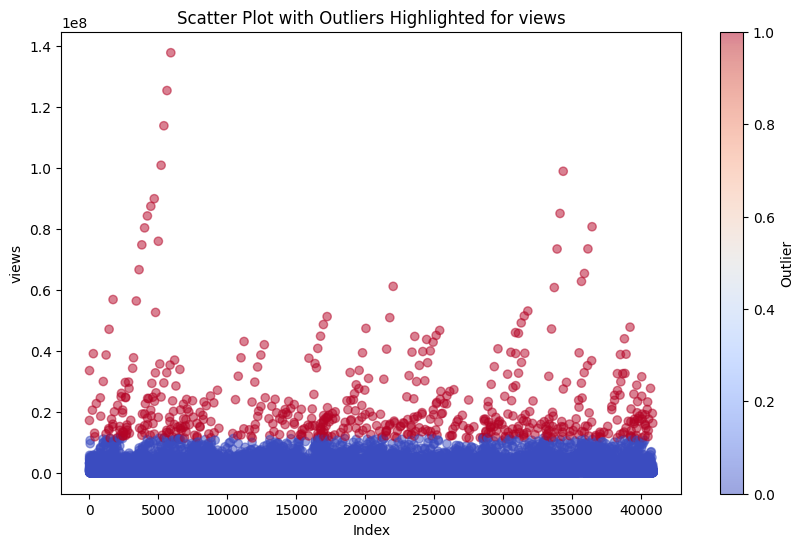

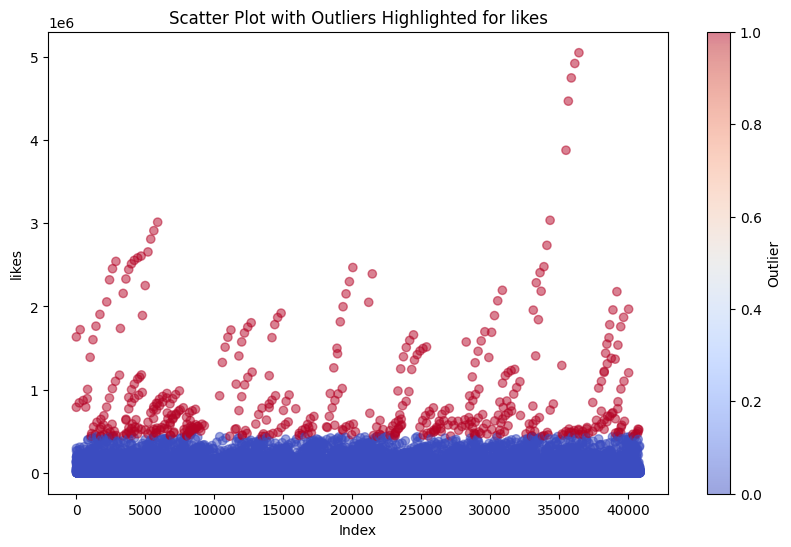

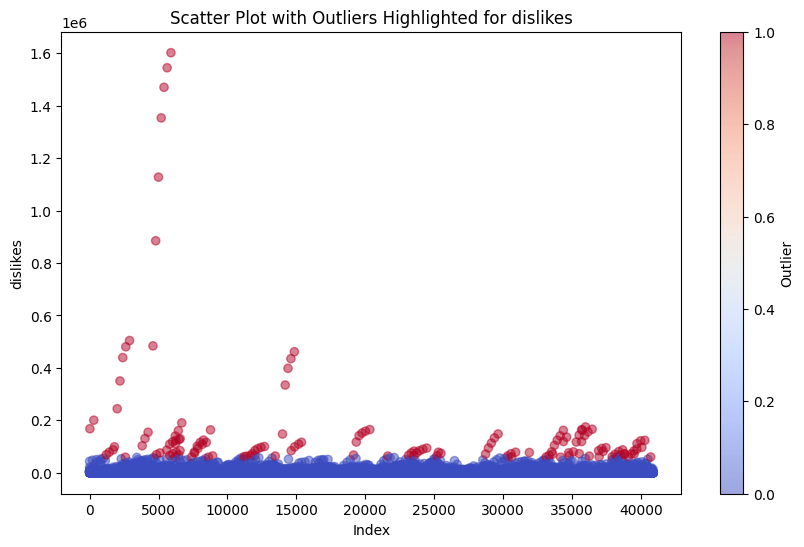

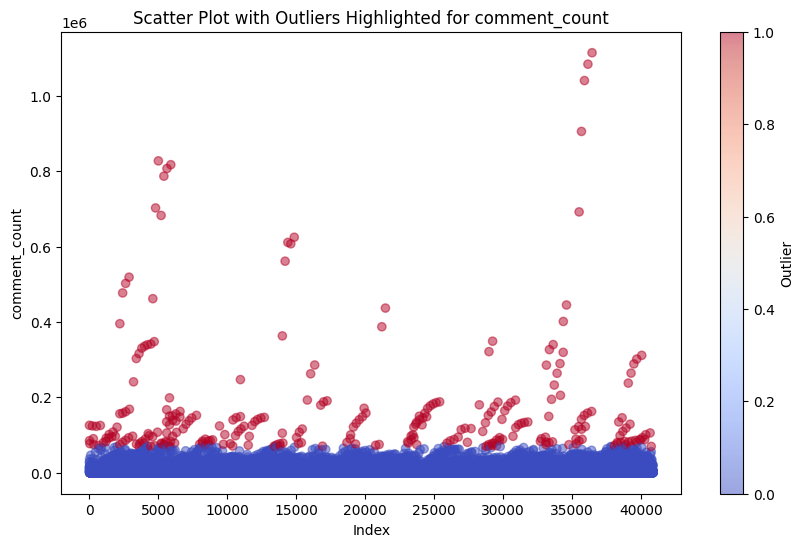

In [29]:
# visualization to outliers
for column in ['views', 'likes', 'dislikes', 'comment_count']:
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, df[column], c=df_outliers[column].astype(int), cmap='coolwarm', alpha=0.5)
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.title(f'Scatter Plot with Outliers Highlighted for {column}')
    plt.colorbar(label='Outlier')
    plt.show()

> Correlation Matrix and Heatmap Visualization

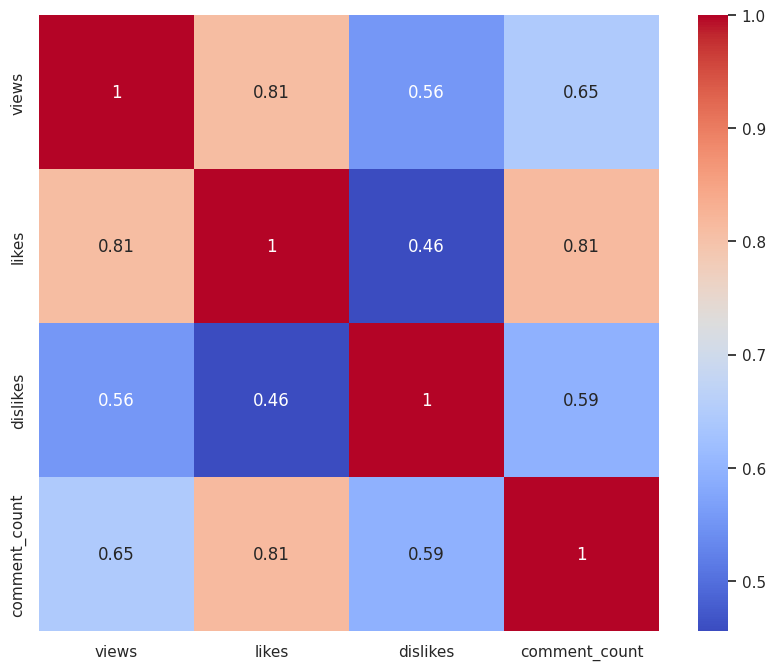

In [453]:
numeric_df = df.select_dtypes(include=['float64', 'int64']) # Select numerical columns (float64, int64)
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(10,8))  # Set figure size for the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


* There is a high correlation of 0.81 between views and likes. This indicates that as the number of views on a video increases, the number of likes generally also increases. In other words, videos with more views tend to receive more likes as well.

* There is a correlation of 0.65 between views and comment_count. This suggests that while the number of comments increases as views rise, the relationship is not as strong as the one between views and likes.

* A positive correlation of 0.81 exists between likes and comment_count, indicating that as the number of likes increases, the number of comments also tends to rise. This could imply that people who like a video are also more likely to leave a comment.

* Dislikes have a lower correlation with other variables. The correlation with views is 0.56, meaning that while the dislike rate increases with the number of views, it is not as strong as the correlation with likes.

* There is a correlation of 0.59 between comment_count and dislikes, which shows that as the number of comments increases, the number of dislikes also tends to increase to some extent.

# Data Visualization

> Channel With The Most View Count

In [454]:
df_Views_Analysis = df_maxViews.groupby('Video_Category')["views"].sum().reset_index()
df_Like = df_maxViews.groupby('Video_Category')["likes"].sum().reset_index()
df_Dislike = df_maxViews.groupby('Video_Category')["dislikes"].sum().reset_index()
df_Comments = df_maxViews.groupby('Video_Category')["comment_count"].sum().reset_index()
df_Views_Analysis["Likes"] = df_Like.likes
df_Views_Analysis["Dislikes"] = df_Dislike.dislikes
df_Views_Analysis["comment_count"] = df_Comments.comment_count
df_Views_Analysis

,Video_Category,views,Likes,Dislikes,comment_count
0,Autos & Vehicles,119562221,3280828,113746,660392
1,Comedy,1700143905,85208699,2420557,8446611
2,Education,271530103,9612006,384975,1396637
3,Entertainment,6039276090,152757629,9110358,21670521
4,Film & Animation,1144171154,27643044,1193466,3598018
5,Gaming,554148910,23470197,1015752,4150155
6,Howto & Style,847351293,26666383,886274,4581432
7,Movies,5661965,67232,3784,3851
8,Music,4893619162,185370631,7464832,16726562
9,News & Politics,901203115,17570852,1765564,5235130


* Statistics by Video Categories; View counts, likes, dislikes, and comment counts are analyzed by video categories.
* Most Popular Categories
    Entertainment and music stand out with high view and like counts.
* High Engagement
    Comedy and gaming categories provide high engagement values.
* Low Engagement
    Other categories generally have lower view and engagement values.



In [455]:
# Selecting Only Numerical Columns
numeric_columns = df.select_dtypes(include=['number']).columns

# Grouping and Summing Operations are Performed Only on Numerical Columns
channel_group_df = df.groupby(by='channel_title')[numeric_columns].sum()

# Channel with the Highest View Count
top_channel = channel_group_df[channel_group_df['views'] == channel_group_df['views'].max()]
top_channel

,views,likes,dislikes,comment_count
channel_title,,,,
T-Series,2.633272,1.22753,0.268585,0.39007


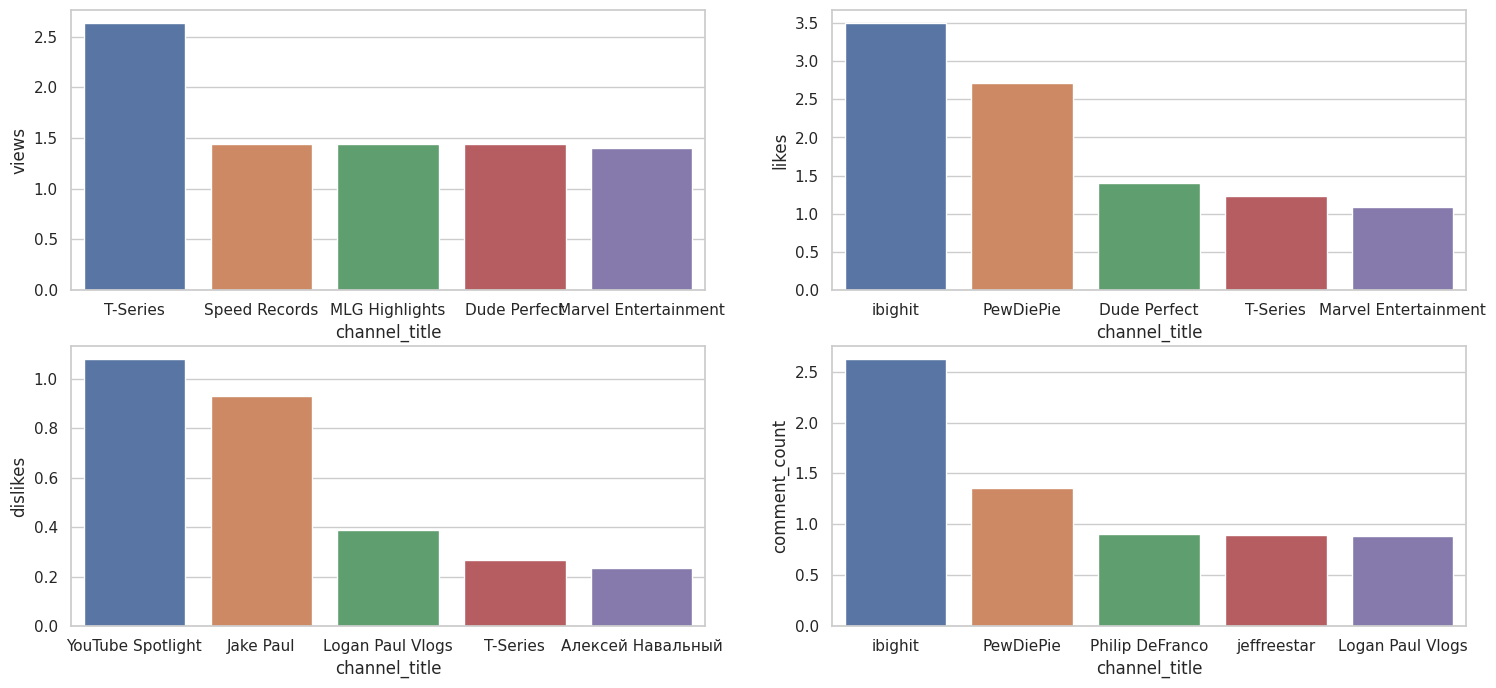

In [456]:
#Plotting the 5 channels with largest view count, likes, dislikes, comment_count
plt.figure(figsize = (18,8))
plt.subplot(2,2,1)

var_list = ['views','likes','dislikes','comment_count']

for i in range(0,4):
    plt.subplot(2,2,i+1)
    x = channel_group_df[var_list[i]].nlargest(5).index
    y = channel_group_df[var_list[i]].nlargest(5)
    sns.barplot(x = x,y = y)



# **Most Watched Category**

In [457]:
# Select only numerical columns
numeric_columns = df.select_dtypes(include=['number']).columns

# Group by Video_Category and sum the numerical columns
category_group_df = df.groupby(by='Video_Category')[numeric_columns].sum()
category_group_df


,views,likes,dislikes,comment_count
Video_Category,,,,
Autos & Vehicles,0.870193,0.653087,0.071158,0.594034
Comedy,12.382001,16.922028,1.515915,7.594861
Education,1.978642,1.931458,0.241434,1.265466
Entertainment,43.983631,30.425886,5.702821,19.556115
Film & Animation,8.189879,5.369713,0.727907,3.155374
Gaming,4.044140,4.679237,0.635481,3.764610
Howto & Style,6.066559,5.296838,0.550015,4.133302
Movies,0.041068,0.013304,0.002361,0.003454
Music,36.445022,37.435599,4.736296,15.284121


In [458]:
category_group_df[category_group_df['views'] == category_group_df['views'].max()]

,views,likes,dislikes,comment_count
Video_Category,,,,
Entertainment,43.983631,30.425886,5.702821,19.556115


Find and display the category with the highest view count, which is Entertainment with 43,983,631 views.


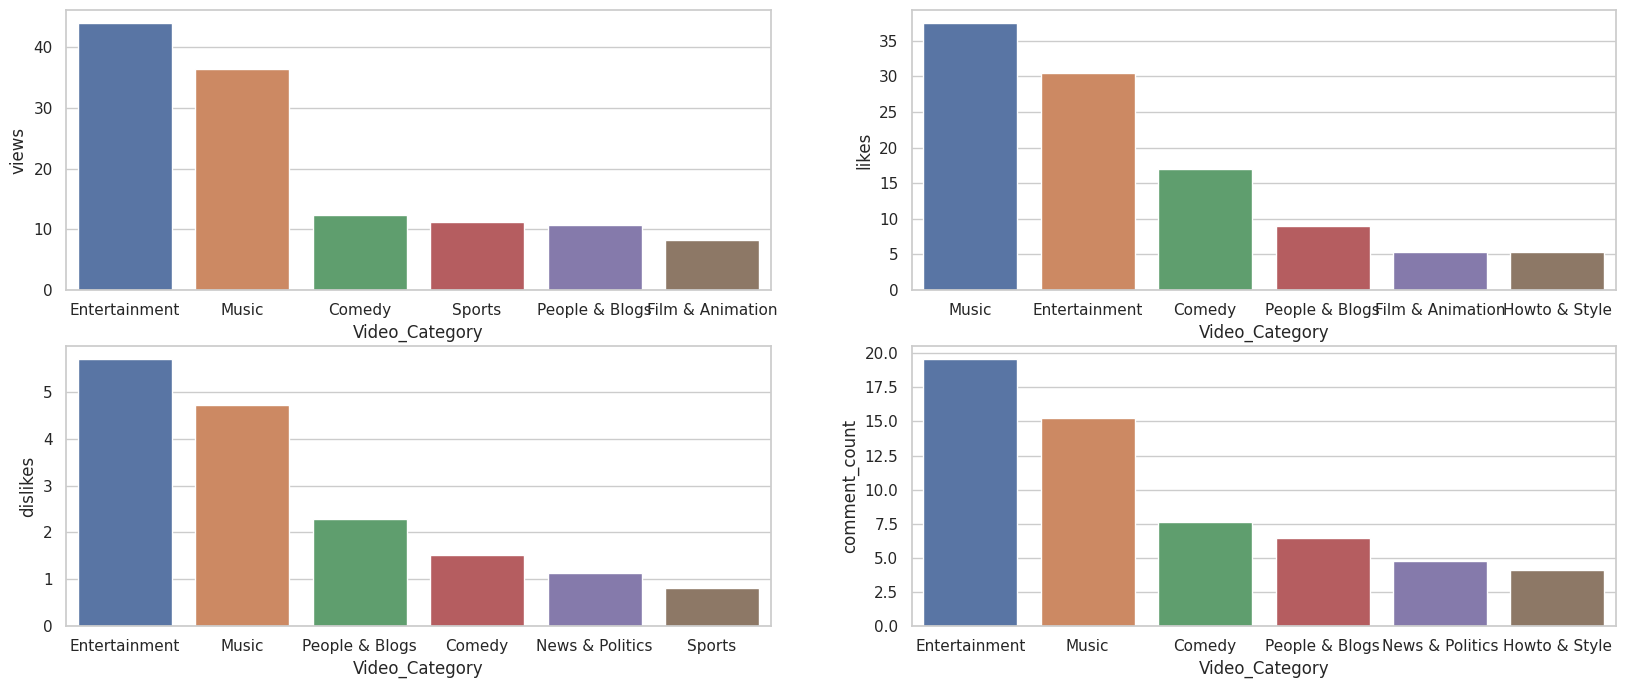

In [459]:
#Plotting the 5 categories with largest view count, likes, dislikes, comment_count
plt.figure(figsize = (20,8))
plt.subplot(2,2,1)

var_list = ['views','likes','dislikes','comment_count']

for i in range(0,4):
    plt.subplot(2,2,i+1)
    x = category_group_df[var_list[i]].nlargest(6).index
    y = category_group_df[var_list[i]].nlargest(6)
    sns.barplot(x = x,y = y)

The most popular YouTube category in Canada is "Entertainment," which has the highest view count as well as the most dislikes and comments. The "Music" category ranks second in views, dislikes, and comments, but stands out with the most likes.




# **Least Watched Category**

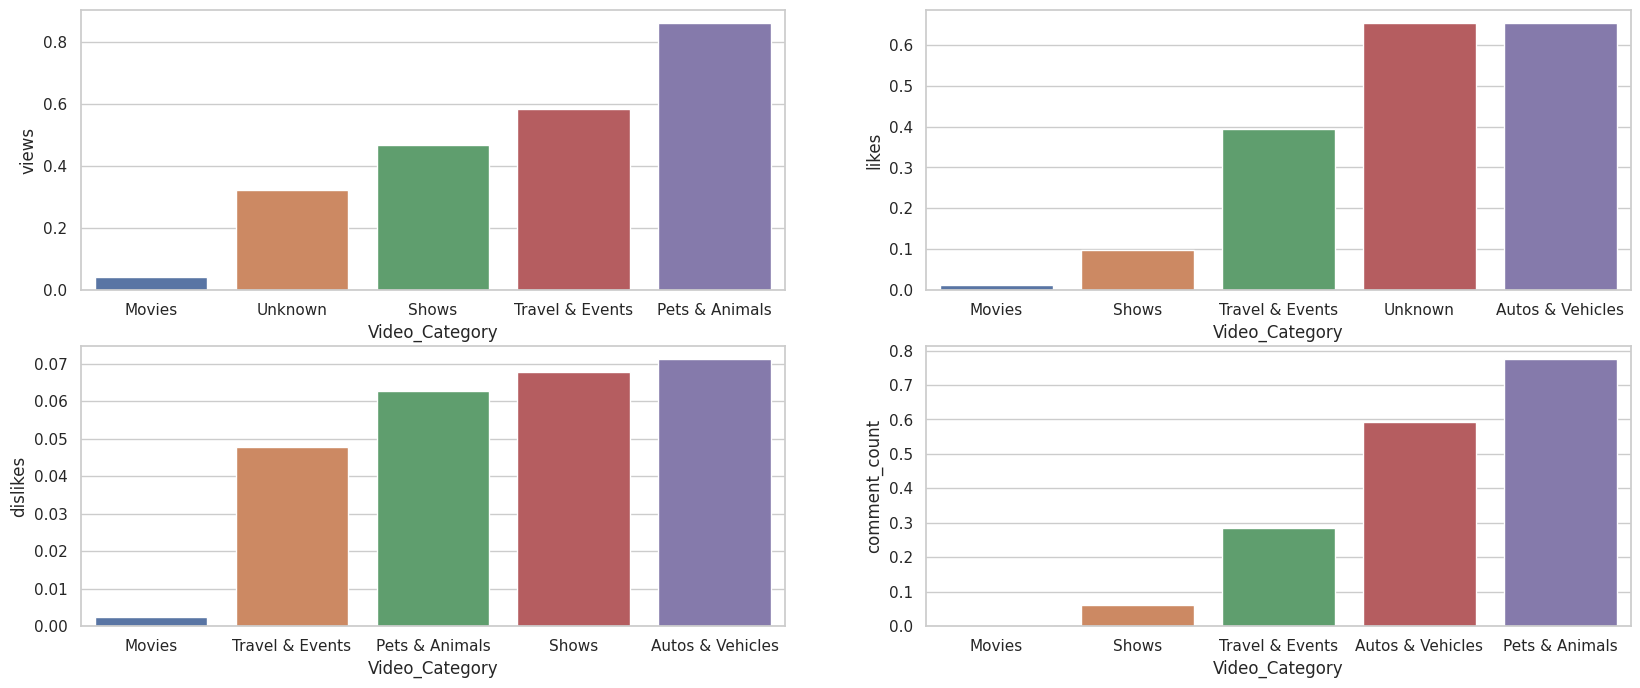

In [460]:
#Plotting the 5 Categories with smallest view count, likes, dislikes, comment_count 
plt.figure(figsize = (20,8))
plt.subplot(2,2,1)

var_list = ['views','likes','dislikes','comment_count']

for i in range(0,4):
    plt.subplot(2,2,i+1) 
    x = category_group_df[var_list[i]].nsmallest(5).index
    y = category_group_df[var_list[i]].nsmallest(5)
    sns.barplot(x = x,y = y)

"Movies" is the category with the lowest view count, likes, comments, and dislikes.



# Response Percentage Column

In [461]:
df_Views_Analysis["Response_Percentage"] = round((( df_Views_Analysis.Likes + df_Views_Analysis.Dislikes ) /df_Views_Analysis.views)* 100,2)
df_Views_Analysis

,Video_Category,views,Likes,Dislikes,comment_count,Response_Percentage
0,Autos & Vehicles,119562221,3280828,113746,660392,2.84
1,Comedy,1700143905,85208699,2420557,8446611,5.15
2,Education,271530103,9612006,384975,1396637,3.68
3,Entertainment,6039276090,152757629,9110358,21670521,2.68
4,Film & Animation,1144171154,27643044,1193466,3598018,2.52
5,Gaming,554148910,23470197,1015752,4150155,4.42
6,Howto & Style,847351293,26666383,886274,4581432,3.25
7,Movies,5661965,67232,3784,3851,1.25
8,Music,4893619162,185370631,7464832,16726562,3.94
9,News & Politics,901203115,17570852,1765564,5235130,2.15


To help evaluate how actively viewers are responding to a video, created a "Response Percentage" column to measure public reactions. This column will show viewer engagement by calculating the ratio of responses (likes, dislikes, comments) to the total number of views.


Text(0, 0.5, 'Public Response(in percentage)')

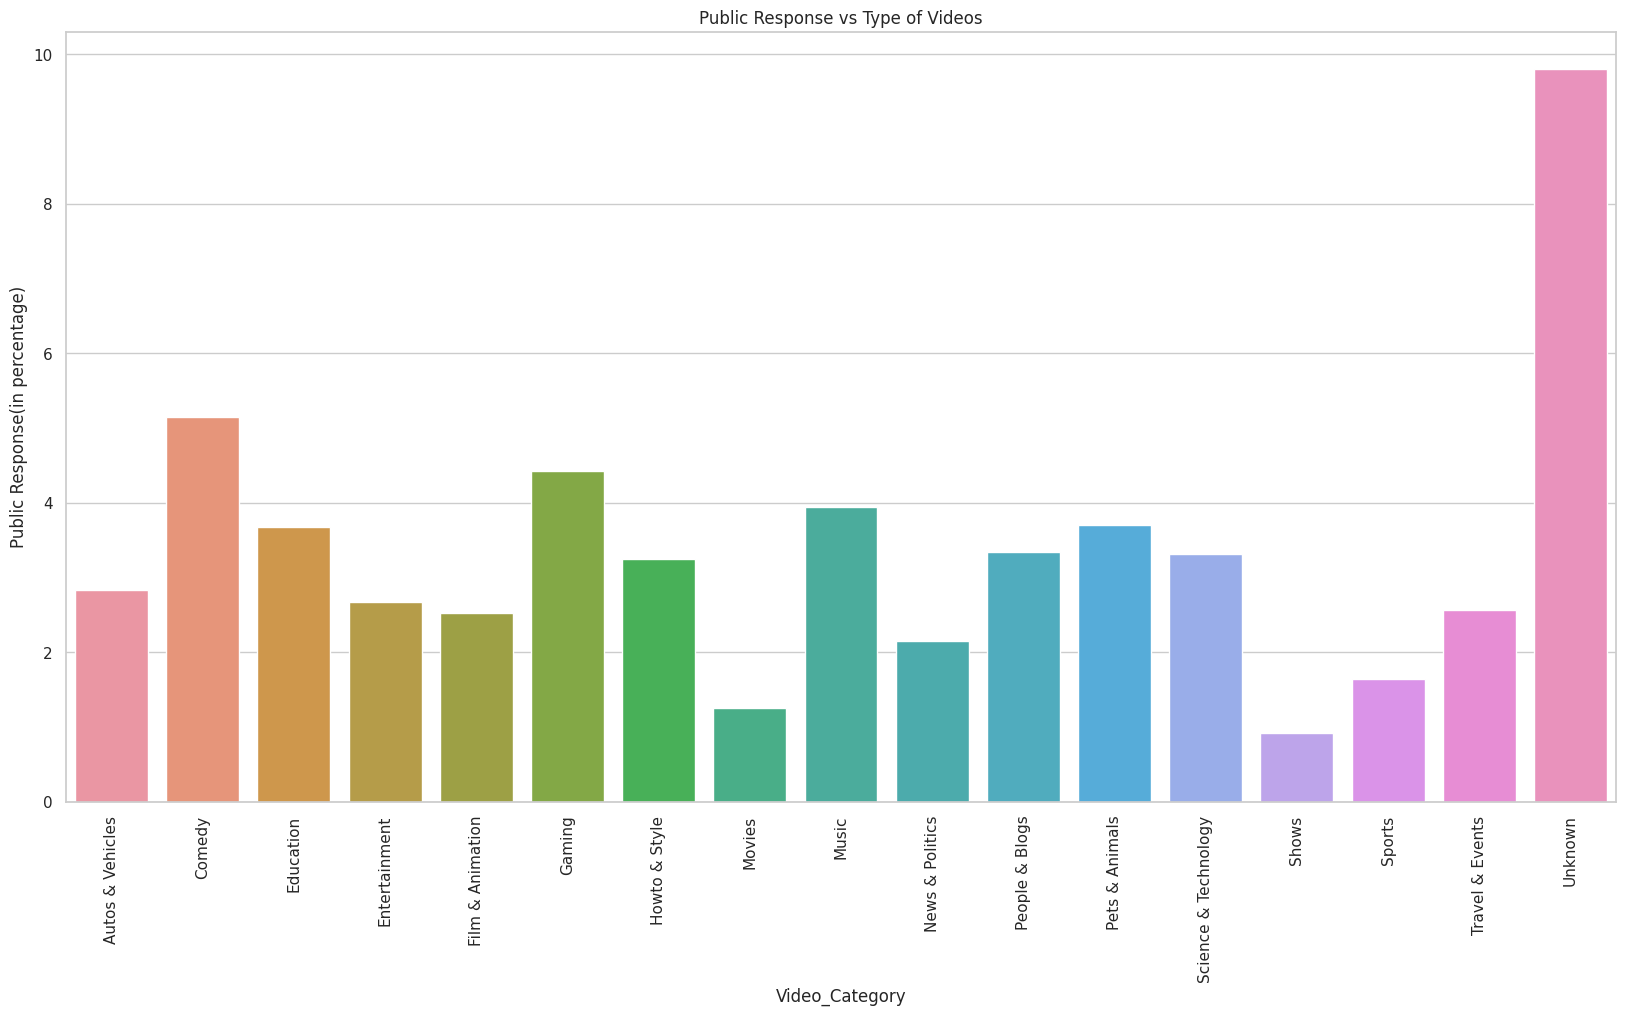

In [462]:
# Set the width and height of the figure
plt.figure(figsize=(20,10))

# Add title
plt.title("Public Response vs Type of Videos")
plt.xticks(rotation=90)

sns.barplot(x=df_Views_Analysis.Video_Category, y=df_Views_Analysis.Response_Percentage)

# Add label for vertical axis
plt.ylabel("Public Response(in percentage)")

So now, We can see that Viewers are highly reacting to Unknown , comedy, gaming and music

We will calculate "Similar Percentages" to analyze and interpret the insights they provide. This will help us understand patterns and trends in public engagement across different videos.



In [463]:
df_Views_Analysis["LikesPercentage"] = df_Views_Analysis.Likes*100/df_Views_Analysis.views
df_Views_Analysis["DislikesPercentage"] = df_Views_Analysis.Dislikes*100/df_Views_Analysis.views
df_Views_Analysis["Comments"] = df_Comments["comment_count"]
df_Views_Analysis["CommentsPercentage"] = df_Views_Analysis.Comments*100/df_Views_Analysis.views
df_Views_Analysis

,Video_Category,views,Likes,Dislikes,comment_count,Response_Percentage,LikesPercentage,DislikesPercentage,Comments,CommentsPercentage
0,Autos & Vehicles,119562221,3280828,113746,660392,2.84,2.744034,0.095135,660392,0.552342
1,Comedy,1700143905,85208699,2420557,8446611,5.15,5.011852,0.142374,8446611,0.496817
2,Education,271530103,9612006,384975,1396637,3.68,3.539941,0.141780,1396637,0.514358
3,Entertainment,6039276090,152757629,9110358,21670521,2.68,2.529403,0.150852,21670521,0.358826
4,Film & Animation,1144171154,27643044,1193466,3598018,2.52,2.415989,0.104308,3598018,0.314465
5,Gaming,554148910,23470197,1015752,4150155,4.42,4.235359,0.183299,4150155,0.748924
6,Howto & Style,847351293,26666383,886274,4581432,3.25,3.147028,0.104593,4581432,0.540677
7,Movies,5661965,67232,3784,3851,1.25,1.187432,0.066832,3851,0.068015
8,Music,4893619162,185370631,7464832,16726562,3.94,3.788007,0.152542,16726562,0.341804
9,News & Politics,901203115,17570852,1765564,5235130,2.15,1.949711,0.195912,5235130,0.580905


<Axes: xlabel='Video_Category'>

<Figure size 2000x1000 with 0 Axes>

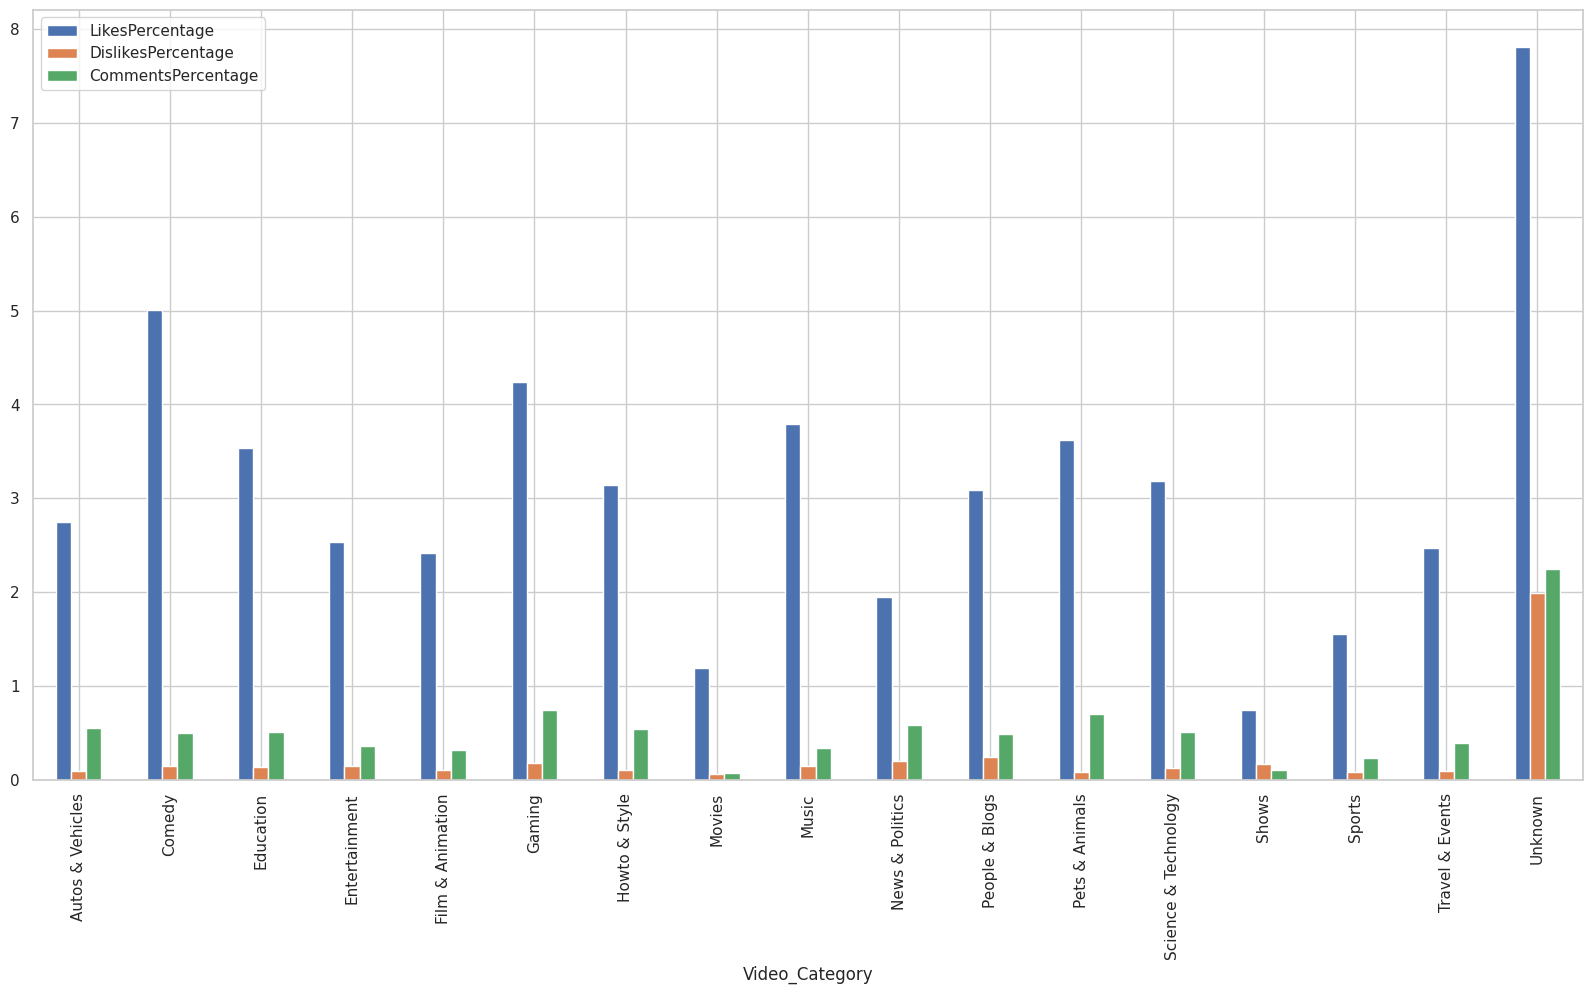

In [464]:
# Set the width and height of the figure
plt.figure(figsize=(20,10))

df_Views_Analysis.plot(x="Video_Category", y=["LikesPercentage", "DislikesPercentage", "CommentsPercentage"], kind="bar",figsize=(20,10))

# **CommentsPercentage vs Type of Videos**

Text(0, 0.5, 'Comments')

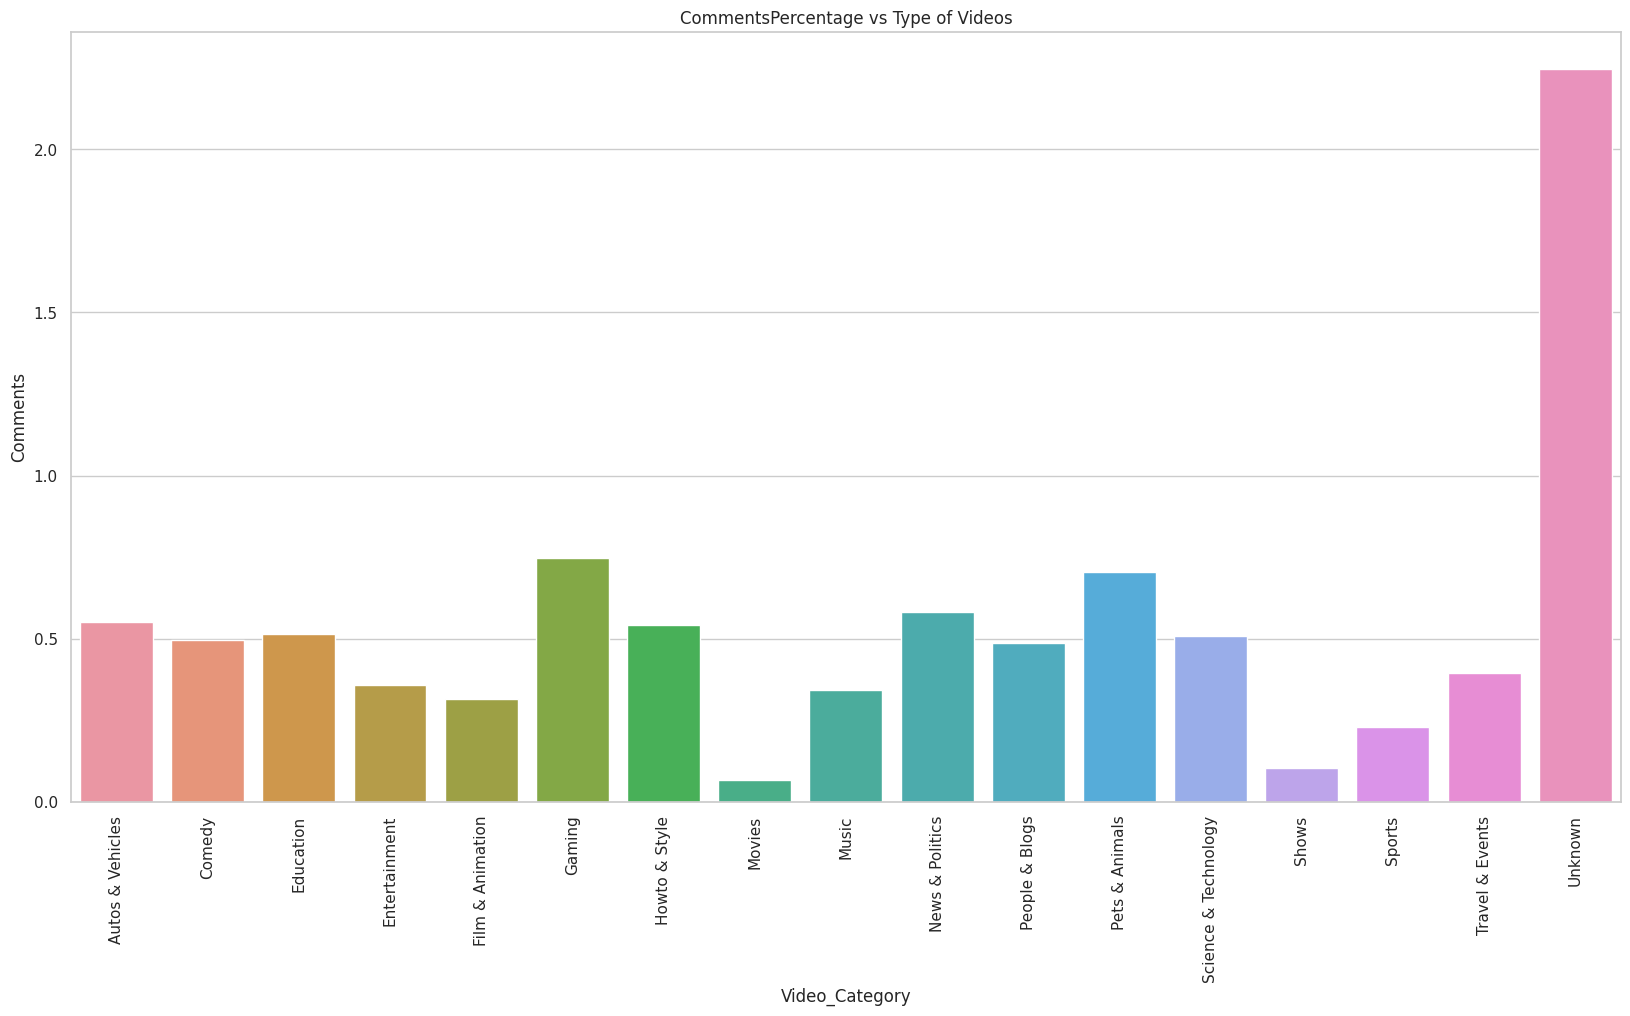

In [465]:
# Set the width and height of the figure
plt.figure(figsize=(20,10))

# Add title
plt.title("CommentsPercentage vs Type of Videos")
plt.xticks(rotation=90)

sns.barplot(x=df_Views_Analysis.Video_Category, y=df_Views_Analysis.CommentsPercentage)

# Add label for vertical axis
plt.ylabel("Comments")

Unknown category, Gaming, pets & Animals, News & Politics has the most comment

Text(0, 0.5, 'Dislikes')

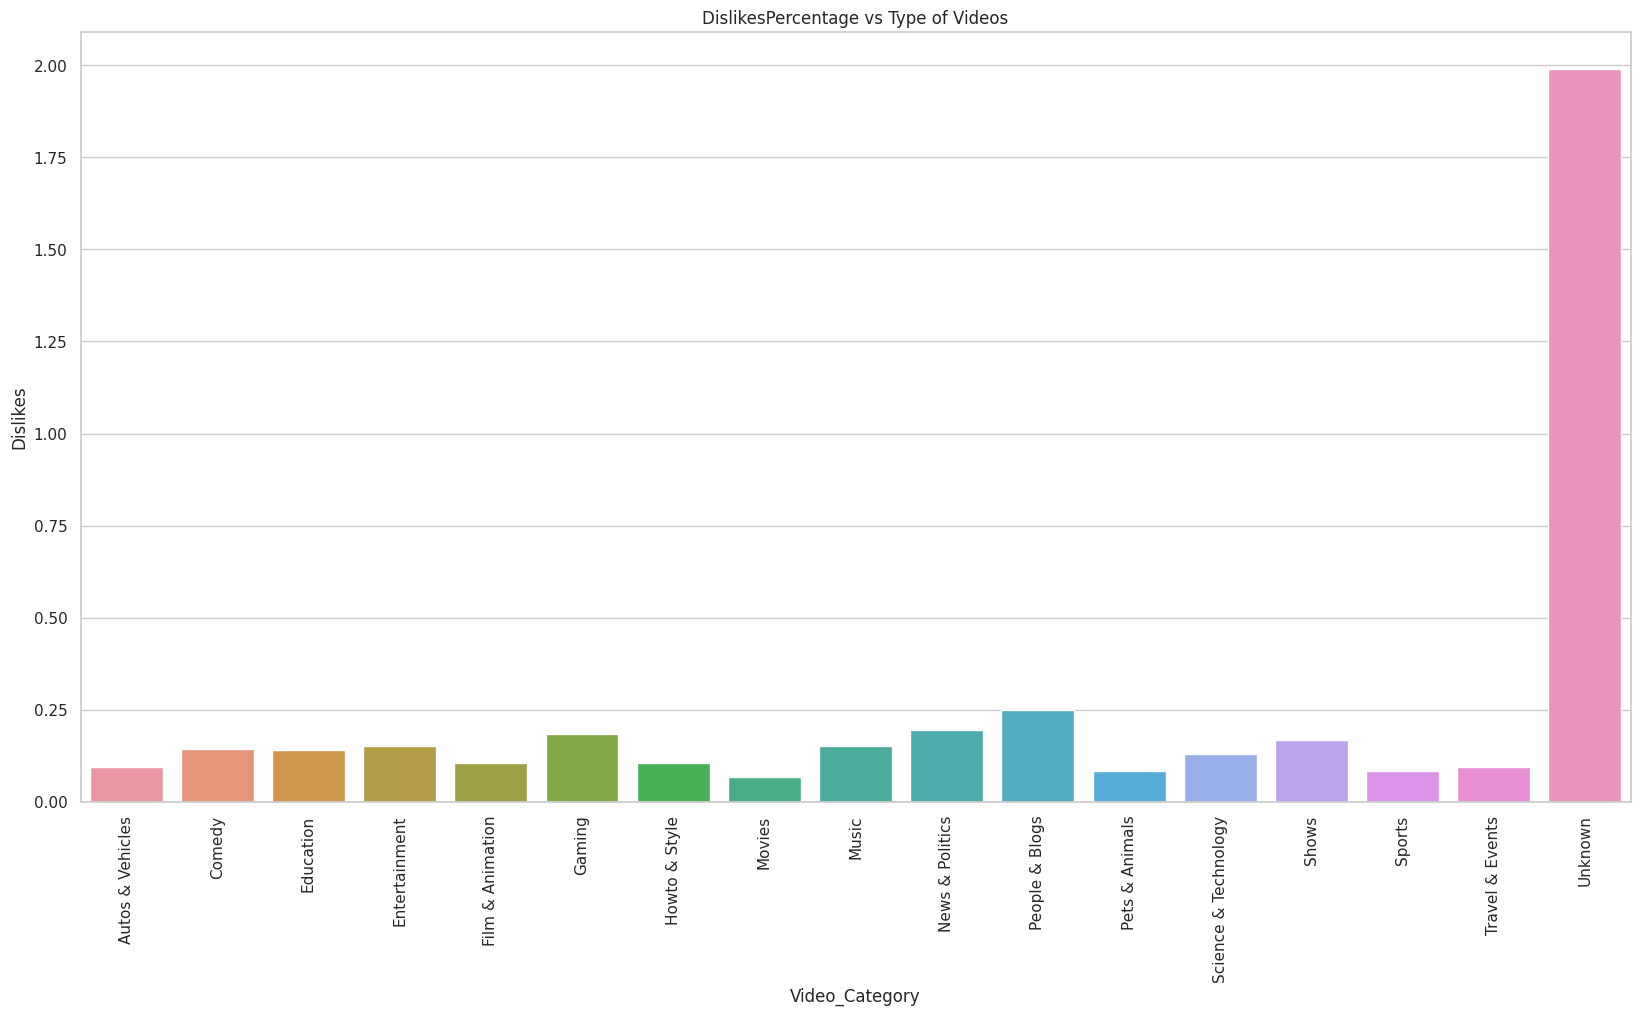

In [466]:
# Set the width and height of the figure
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)

# Add title
plt.title("DislikesPercentage vs Type of Videos")

sns.barplot(x=df_Views_Analysis.Video_Category, y=df_Views_Analysis.DislikesPercentage)

# Add label for vertical axis
plt.ylabel("Dislikes")

Unknown and the People & blogs to receive the most dislikes

Text(0, 0.5, 'Likes')

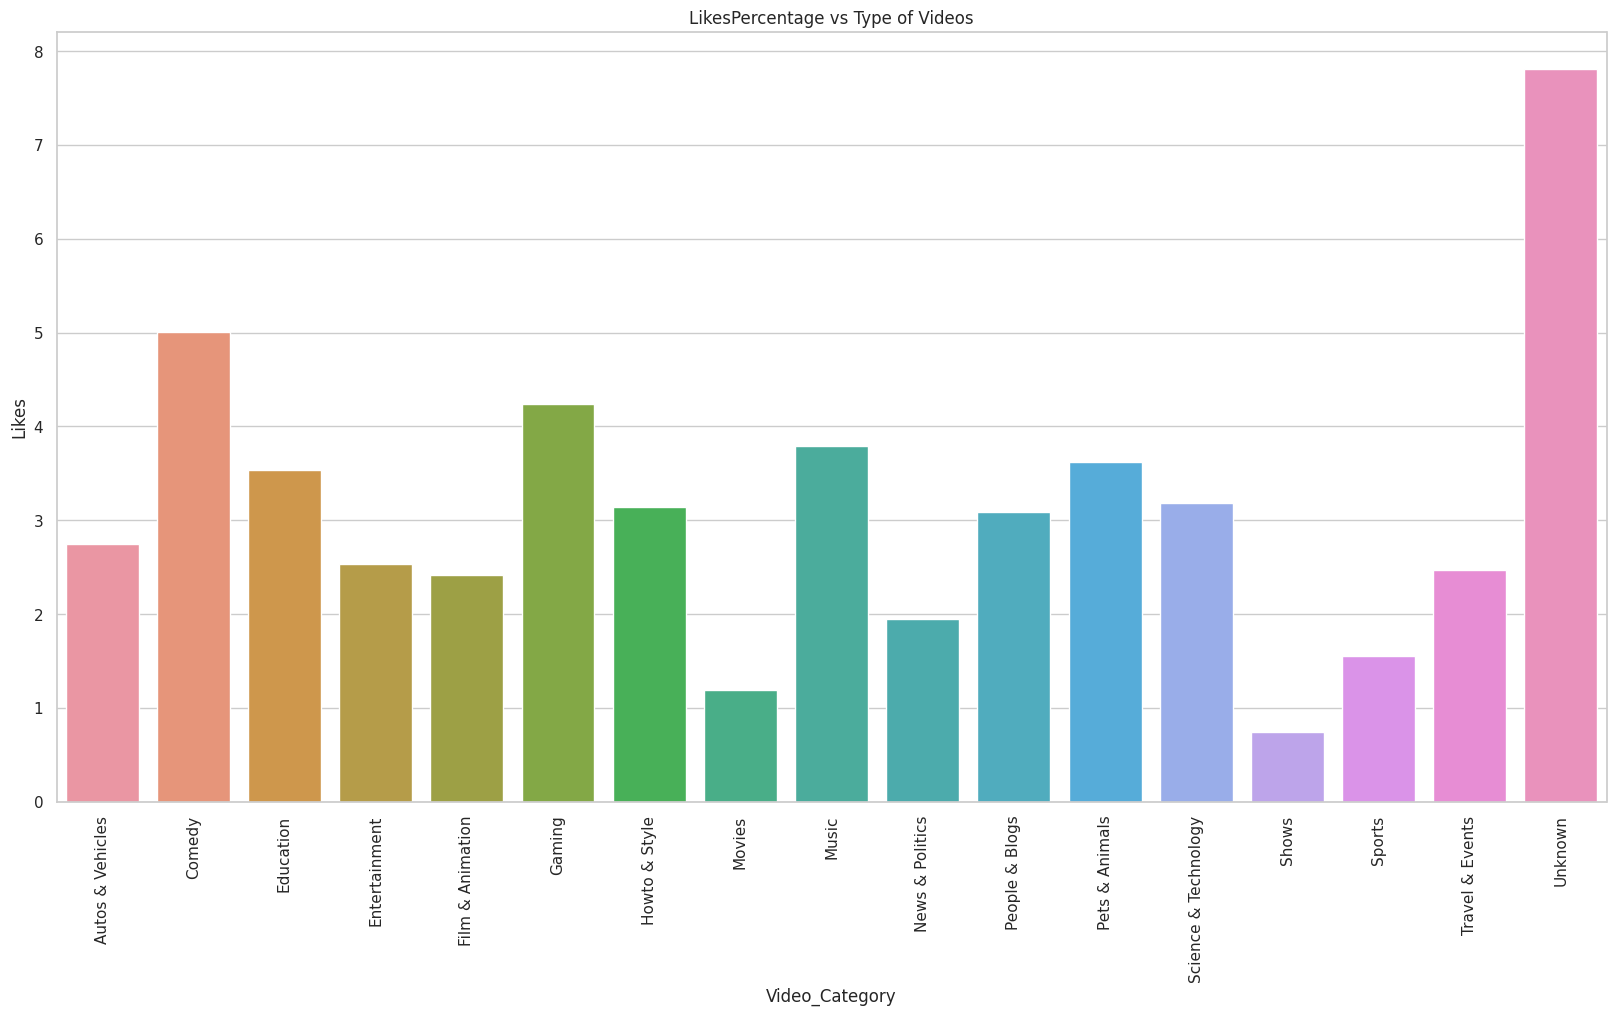

In [467]:
# Set the width and height of the figure
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)

# Add title
plt.title("LikesPercentage vs Type of Videos")

sns.barplot(x=df_Views_Analysis.Video_Category, y=df_Views_Analysis.LikesPercentage)

# Add label for vertical axis
plt.ylabel("Likes")

Comedy, gaming and music seems to receive the most likes.

> 

In [468]:
df['trending_year'] = df['trending_date'].dt.year
df['trending_month'] = df['trending_date'].dt.month
df['publish_hour'] = df['publish_time'].dt.hour


* We divided the date and time into components like year, month, and hour to create numerical features.

In [469]:
df['comments_disabled'] = df['comments_disabled'].astype(int)
df['ratings_disabled'] = df['ratings_disabled'].astype(int)
df['video_error_or_removed'] = df['video_error_or_removed'].astype(int)


* Boolean data was converted into numerical values.

> One-hot encoding

In [470]:
df = pd.get_dummies(df, columns=['Video_Category'], drop_first=True)

The Video_Category column was converted using one-hot encoding.

In [471]:
df.dtypes

video_id                                            object
trending_date                               datetime64[ns]
title                                               object
channel_title                                       object
category_id                                       category
publish_time                           datetime64[ns, UTC]
tags                                                object
views                                              float64
likes                                              float64
dislikes                                           float64
comment_count                                      float64
comments_disabled                                    int64
ratings_disabled                                     int64
video_error_or_removed                               int64
description                                         object
trending_year                                        int32
trending_month                                       int

> Converting Text Data into Numerical Values

In [473]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#Text Cleaning Function:
def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation marks
    tokens = word_tokenize(text)  # Tokenize the text into words
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stop words
    return ' '.join(tokens)

#Cleaning Operation
df['clean_title'] = df['title'].apply(preprocess_text)
df['clean_channel_title'] = df['channel_title'].apply(preprocess_text)
df['clean_tags'] = df['tags'].apply(preprocess_text)
df['clean_description'] = df['description'].apply(preprocess_text)


In [474]:
#TF-IDF Vectorization Setup
# Create TF-IDF vectorizers for different text columns
vectorizer_title = TfidfVectorizer()
vectorizer_channel_title = TfidfVectorizer()
vectorizer_tags = TfidfVectorizer()
vectorizer_description = TfidfVectorizer()

# Convert the cleaned text data to TF-IDF vectors
tfidf_title = vectorizer_title.fit_transform(df['clean_title'])
tfidf_channel_title = vectorizer_channel_title.fit_transform(df['clean_channel_title'])
tfidf_tags = vectorizer_tags.fit_transform(df['clean_tags'])
tfidf_description = vectorizer_description.fit_transform(df['clean_description'])


# Model Selection and Training - Supervised Learning

> Splitting the Data into Training and Test Sets

In [276]:
# X: Features, y: Target column
X = df.drop('views', axis=1)  # We drop the 'views' column because it is the target column
y = df['views']  # The target column we are trying to predict

from sklearn.model_selection import train_test_split

# Split the data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


> RandomForestRegressor

In [233]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Features and target variable
X = df.drop('views', axis=1)  # 'views' is the target variable, so it is dropped
y = df['views']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Remove non-numeric data
df = df.select_dtypes(include=[np.number])

# Create and train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))


Mean Squared Error: 7.352118956574438e-05


In [234]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print("R^2 Skoru:", r2)


R^2 Skoru: 0.807354926967141


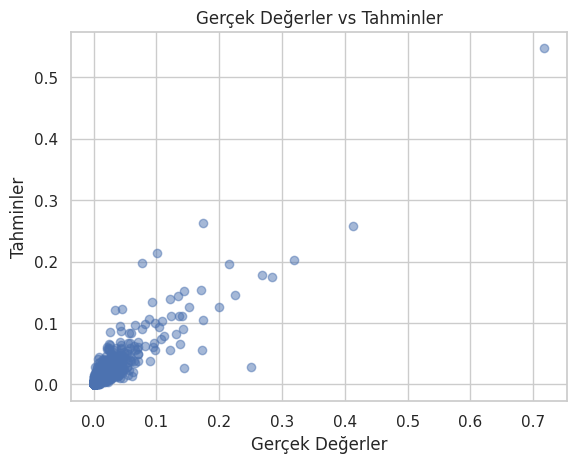

In [235]:
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_test)

# Actual values and predictions
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahminler')
plt.title('Gerçek Değerler vs Tahminler')
plt.show()



What Did We Do with the Random Forest Model?

* Data Preparation: We converted the data to numerical format, removed unnecessary columns, and separated the features.
* Model Training: We trained our model using the Random Forest Regressor.
* Performance Evaluation: We evaluated the model's performance using metrics such as Mean Squared Error (MSE) and R^2 Score.

# Model Selection and Training - Unsupervised Learning

> KMeans Clustering

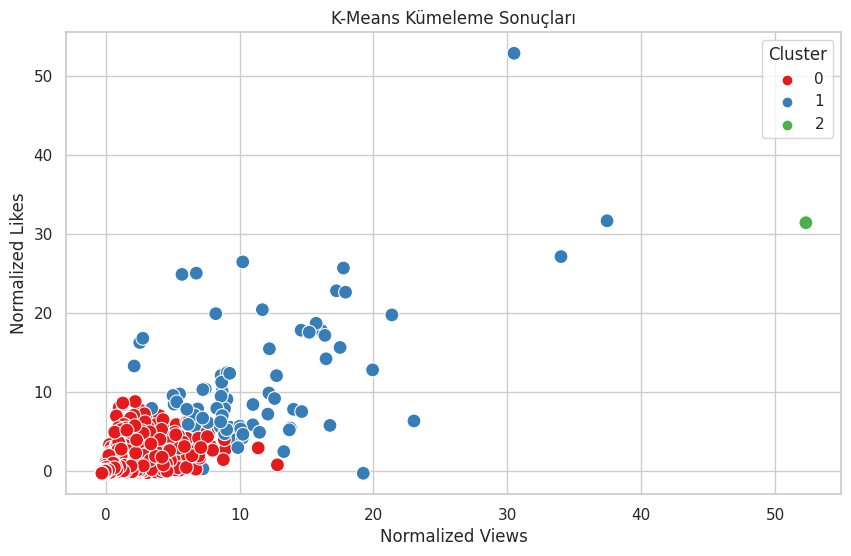

In [51]:
# Gerekli kütüphaneleri ekleyelim
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Veriyi normalleştirme
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['views', 'likes', 'dislikes', 'comment_count']])

# k-Means modeli oluşturma (k=3 ile 3 küme için)
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# Kümeleme sonuçlarını görselleştirme
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_scaled[:, 0], y=df_scaled[:, 1], hue=df['Cluster'], palette='Set1', s=100)
plt.title("K-Means Kümeleme Sonuçları")
plt.xlabel("Normalized Views")
plt.ylabel("Normalized Likes")
plt.show()


Explanations:

* StandardScaler: Normalizes the data to prevent extreme differences in numerical values from affecting clustering.
* KMeans(n_clusters=3): We set the number of clusters (k) to 3, meaning we will create 3 clusters.
* fit_predict(): While training the model, assigns each data point to a cluster and returns the results.
* Scatter plot: Visualizes the clustering results.

In [596]:
from sklearn.metrics import silhouette_score

# Silhouette Score hesaplama
silhouette_avg = silhouette_score(df_scaled, df['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

# Inertia (Küme içi toplam uzaklık) hesaplama
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")


Silhouette Score: 0.9610899682977774
Inertia: 46516.17574444767


Silhouette Score: I use this metric to assess how well my clustering results are. It ranges from -1 to 1.

* Close to 1: When the score is close to 1, it means that my data is well-clustered. Each data point is close to other data points in the same cluster and far from points in other clusters.
* Close to 0: If the score is close to 0, it suggests that the clusters might not be well-separated.
* Negative: A negative score indicates that the data points may be incorrectly placed between clusters.
In my case, a Silhouette Score of 0.961 is quite high, which shows that my clusters are well-separated and the data points are logically grouped within them. This high score indicates that my k-Means algorithm has successfully partitioned the data points into meaningful clusters. On the other hand, the Inertia value alone doesn’t provide much insight; I usually find the optimal number of clusters (k) by adjusting k and evaluating the results.